In [1]:

from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

######################################
# functions we use here
######################################

# function to find the data we need from the traces
def get_inj(T,I,V):
    I_abs = np.abs(I)
    inj_start = np.where(I_abs > I_abs.max() / 4.0)[0][0]
    inj_end = np.where(I_abs > I_abs.max() / 4.0)[0][-1]
    inj = np.median(I[inj_start:inj_end]) 
    return inj, T[inj_start], T[inj_end + 1]

# function to set the model parameters in the fitting
def change_model_pas(CM=1, RA = 250, RM = 20000.0, E_PAS = -70):
    h.distance(0, sec=cell.soma[0])
    for sec in cell.all:
        sec.Ra = RA
        sec.cm = CM
        sec.g_pas = 1.0 / RM
        sec.e_pas = E_PAS
    for sec in cell.basal:
        for seg in sec:
            if h.distance(seg.x) > SPINE_START:
                seg.cm *= F_factor
                seg.g_pas *= F_factor
    for sec in cell.apic:
        for seg in sec:
            if h.distance(seg.x) > SPINE_START:
                seg.cm *= F_factor
                seg.g_pas *= F_factor

    cell.soma[0].Ra=RA
    cell.soma[0].cm=CM
    cell.soma[0].g_pas=1.0 / RM
    cell.soma[0].e_pas = E_PAS
    
# function to plot in the end
def plot_res(RM, RA, CM, save_name= "fit"):
    fig, ax  = plt.subplots(1,2)
    change_model_pas(CM=CM, RA=RA, RM=RM, E_PAS = E_PAS1)
    clamp.amp = inj1
    clamp.dur = inj1_end - inj1_start
    clamp.delay = inj1_start
    Vvec1 = h.Vector()
    Vvec1.record(soma(0.5)._ref_v)
    h.tstop = M1[:,0][-1]
    h.v_init=E_PAS1
    h.run()
    npVec1 = np.array(Vvec1)
    ax[0].plot(M1[:,0], M1[:,2], color = 'k')
    time = np.arange(0,len(npVec1) * h.dt,h.dt)
    ax[0].plot(time, npVec1, color = 'r', linestyle ="--")
    ax[0].set_title("long pulse fit")
    change_model_pas(CM=CM, RA=RA, RM=RM, E_PAS = E_PAS2)
    clamp.amp = inj2
    clamp.dur = inj2_end - inj2_start
    clamp.delay = inj2_start
    Vvec2 = h.Vector()
    Vvec2.record(soma(0.5)._ref_v)
    h.tstop = M2[:,0][-1]
    h.v_init=E_PAS2
    h.run()
    npVec2 = np.array(Vvec2)
    ax[1].plot(M2[:,0], M2[:,2], color = 'k')
    time = np.arange(0,len(npVec2) * h.dt,h.dt)
    ax[1].plot(time, npVec2, color = 'r', linestyle ="--")
    ax[1].set_xlabel("time (ms)")
    ax[1].set_ylabel("V (mv)")
    ax[1].set_title("short pulse fit")


######################################
# some constants
######################################

F_factor = 1.5
SPINE_START = 60

######################################
# loading the  model
# we use a hoc template in order to load the morphology
######################################
post_morph_dir = "fitting_exsamale/morph.swc"
h.load_file("import3d.hoc")
h.load_file("nrngui.hoc")
h("objref cell, tobj")

morph_file = post_morph_dir
model_file = "template_model"
model_path = "fitting_exsamale/"
h.load_file(model_path + model_file + ".hoc")
h.execute("cell = new " + model_file + "()") 

nl = h.Import3d_SWC_read()
nl.quiet = 1
nl.input(morph_file)
imprt = h.Import3d_GUI(nl, 0)
imprt.instantiate(h.cell)
cell = h.cell
cell.geom_nseg()
cell.delete_axon()
cell.biophys()

#inserting passive mechanism
for sec in cell.all:
    sec.insert("pas")

# set a current clamp
soma = cell.soma[0]
clamp = h.IClamp(soma(0.5))


In [2]:
######################################
# load the data and see what we have
######################################

long_pulse = "fitting_exsamale/long_pulse.txt"
M1 = np.loadtxt(long_pulse)
M1[:,1] -= M1[:,1][0]
inj1, inj1_start, inj1_end = get_inj(M1[:,0], M1[:,1], M1[:,2])
E_PAS1 = np.mean(M1[:,2][:200]) # get e pas as the mean of the start of the trace

short_pulse = "fitting_exsamale/short_pulse.txt"
M2 = np.loadtxt(short_pulse)
E_PAS2 = np.median(M2[:,2][:200]) # get e pas as the mean of the start of the trace
inj2, inj2_start, inj2_end = get_inj(M2[:,0], M2[:,1], M2[:,2])


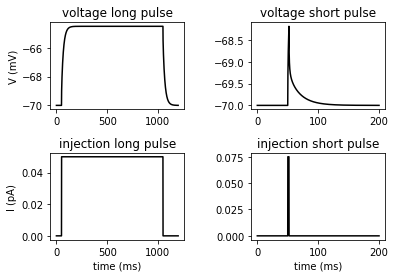

In [3]:
######################################
#plotting the expirement data
######################################

fig, ax = plt.subplots(2,2)
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
ax[0][0].set_title("voltage long pulse")
ax[0][0].plot(M1[:,0], M1[:,2], color="k")

ax[1][0].set_title("injection long pulse")
ax[1][0].plot(M1[:,0], M1[:,1], color="k")

ax[0][1].set_title("voltage short pulse")
ax[0][1].plot(M2[:,0], M2[:,2], color="k")

ax[1][1].set_title("injection short pulse")
ax[1][1].plot(M2[:,0], M2[:,1], color="k")

ax[0][0].set_ylabel("V (mV)")
ax[1][0].set_ylabel("I (pA)")
ax[1][1].set_xlabel("time (ms)")
ax[1][0].set_xlabel("time (ms)")
plt.show()




In [4]:
# objective function (error function)
def efun(vals):
    if RM_IX != -1 :
        if vals.x[RM_IX] > 100000:
            return (1e6)
        RM = vals.x[RM_IX]
    else: RM = 25000

    if CM_IX != -1:
        if vals.x[CM_IX] > 2 :
            return (1e6)
        CM = vals.x[CM_IX]
    else:CM = 1
    if RA_IX != -1:
        if vals.x[RA_IX] > 350:
            return (1e6)
        RA = vals.x[RA_IX]
    else:RA = RA
    if (CM < 0.3 or RM < 5000 or RA < 100):
        return 1e6
    change_model_pas(CM=CM, RA=RA, RM = RM, E_PAS = E_PAS1)
    clamp.amp = inj1
    clamp.dur = inj1_end - inj1_start
    clamp.delay = inj1_start
    Vvec1 = h.Vector()
    Vvec1.record(soma(0.5)._ref_v)
    h.v_init=E_PAS1
    h.tstop = M1[:,0][-1]
    h.run()
    npVec1 = np.array(Vvec1)
    error_1 = abs(npVec1.max()- M1[:,2].max()) # change to min if the injection is negative
    change_model_pas(CM=CM, RA=RA, RM = RM, E_PAS = E_PAS2)
    clamp.amp = inj2
    clamp.dur = inj2_end - inj2_start
    clamp.delay = inj2_start
    Vvec2 = h.Vector()
    Vvec2.record(soma(0.5)._ref_v)
    exp_data = M2[:,2]
    h.v_init=E_PAS2
    h.tstop = M2[:,0][-1]
    h.run()
    npVec2 = np.array(Vvec2)
    fit_start_for_short_pulse = int((inj2_end+1)/h.dt)
    exp_data_fit_part = exp_data[fit_start_for_short_pulse:fit_start_for_short_pulse+int(100/h.dt)]
    sim_data_fit_part = npVec2[fit_start_for_short_pulse:fit_start_for_short_pulse+int(100/h.dt)]
    # mean square error
    error_2 = np.sum(np.sqrt(np.power(exp_data_fit_part - sim_data_fit_part, 2))) 
    if prinnting:
        print("cur error =", error_1 + error_2, " RM=" , RM, " RA=", RA, " CM=" , CM)
    return error_1 + error_2



In [12]:
######################################
# setting the fitting 
######################################

CM_IX = 0
RM_IX=1
RA_IX = 2

RM_const = 220000.0
RA_const = 230.0
CM_const = 1.2

print("free params:")

h.attr_praxis(1e-9,1000,0)
opt_vals = h.Vector(3)
opt_vals.x[RM_IX] =22000.0
opt_vals.x[RA_IX] = 200
opt_vals.x[CM_IX] = 1.2

free params:


this is the case with:   CM =  1.2  RM =  22000.0  RA = 200.0
this is the case with:   CM =  1.2  RM =  22000.0  RA = 200.0


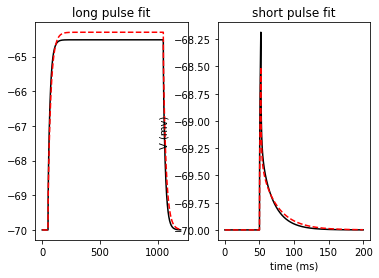

In [15]:
######################################
# how far are we?
######################################
plot_res(CM=opt_vals[CM_IX], RM=opt_vals[RM_IX], RA = opt_vals[RA_IX], save_name="_fit_after_"+str(1))
print("this is the case with: "," CM = ",opt_vals[CM_IX]," RM = ",opt_vals[RM_IX]," RA =", opt_vals[RA_IX])
print("this is the case with: "," CM = ",soma.cm," RM = ",1.0/soma.g_pas," RA =", soma.Ra)

RMSD 24.95095336816425 , RM 18014.162255515057 , RA 349.93104151251276 , CM 1.1485111017392131
RMSD 13.777822365112428 , RM 18737.567132010357 , RA 348.42409268796376 , CM 1.0893402925800812
RMSD 10.712798112330944 , RM 19000.21055079817 , RA 328.40710826775353 , CM 1.0714797385448682


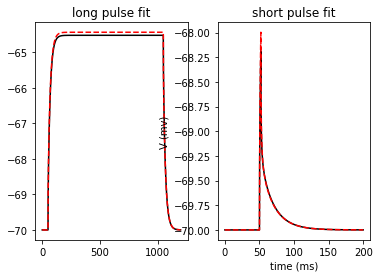

In [16]:
######################################
# running fitting
######################################
prinnting = False # if to print the errors during the fitting
for i in range(3):
    RMSD = h.fit_praxis(efun,opt_vals)

    RM = opt_vals.x[RM_IX]
    RA = opt_vals.x[RA_IX]
    CM = opt_vals.x[CM_IX]

    print("RMSD", RMSD,", RM",  RM, ", RA",  RA, ", CM",  CM)

plot_res(CM=CM, RM=RM, RA = RA, save_name="_fit_after_"+str(i+1))
plt.show()
# import pickle
# pickle.dump({"RMSD":RMSD,"RM":RM, "RA":RA, "CM":CM}, open(""))
